In [126]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d
import pycbc
import pycbc.waveform as wf
from pycbc.detector import Detector
import lalsimulation as lalsim
import lal
#import bilby
from collections import defaultdict
import emcee
import time
import corner

In [2]:
class PSD:
    def __init__(self, psd_filename, prepend_points = [], append_points = []):
        self.f_vals, self.psd_vals = np.loadtxt(psd_filename, unpack = True)
        self.prepend_points = prepend_points
        self.append_points = append_points

        for point in self.prepend_points:
            self.f_vals = np.concatenate([np.array([point[0]]), self.f_vals])
            self.psd_vals = np.concatenate([np.array([point[1]]), self.psd_vals])

        for point in self.append_points:
            self.f_vals = np.concatenate([self.f_vals, np.array([point[0]])])
            self.psd_vals = np.concatenate([self.psd_vals, np.array([point[1]])])

        self.psd = interp1d(self.f_vals, self.psd_vals)

In [3]:
ligo_H1_psd = '/home/mukesh/Academics/EW3/data/GW170814/H1_PSD_GW170814.txt'
ligo_L1_psd = '/home/mukesh/Academics/EW3/data/GW170814/L1_PSD_GW170814.txt'
V1_psd = '/home/mukesh/Academics/EW3/data/GW170814/V1_PSD_GW170814.txt'

H1_psd_int = PSD(ligo_H1_psd)
L1_psd_int = PSD(ligo_L1_psd)
V1_psd_int = PSD(V1_psd)

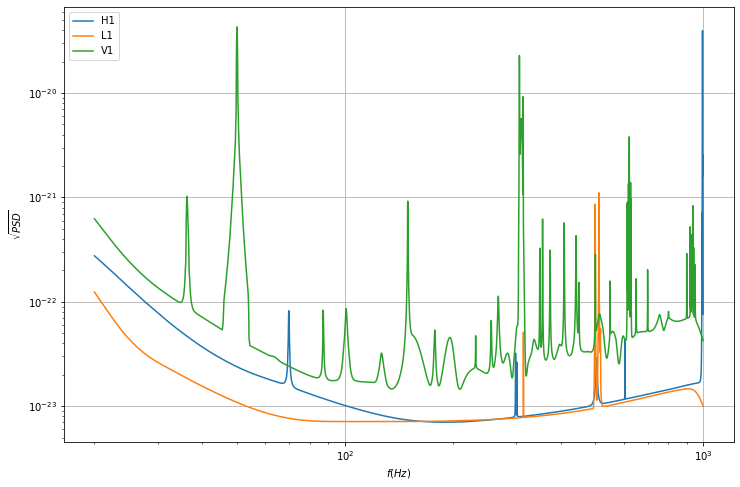

In [4]:
freq = np.linspace(20, 1000, 10000)
plt.figure(figsize=(12,8))
plt.loglog(freq, np.sqrt(H1_psd_int.psd(freq)), label='H1')
plt.loglog(freq, np.sqrt(L1_psd_int.psd(freq)), label='L1')
plt.loglog(freq, np.sqrt(V1_psd_int.psd(freq)), label='V1')
plt.xlabel('$f(Hz)$')
plt.ylabel('$\sqrt{PSD}$')
plt.legend(loc='best')
plt.grid()

In [5]:
def spher_harms_plus_cross_factors(inclination, phi0, l, m):
    
    d_lm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, m).real
    d_lminusm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, -m).real
    Y_lm = lal.SpinWeightedSphericalHarmonic(inclination, phi0, -2, l, m).real
    
    #Notations as deifined in the notes
    C_lm = (((-1)**l)*(d_lminusm/d_lm) + 1)*Y_lm
    D_lm = (((-1)**l)*(d_lminusm/d_lm) - 1)*Y_lm
    
    return C_lm, D_lm

In [88]:
def waveform_lm_mode(fmin, fmax, df, mode, m1, m2, inclination, distance, coa_phase, approx):
    
    mode_array_dict = {
        "22": [[2, 2], [2, -2]],
        "32": [[3, 2], [3, -2]],
        "21": [[2, 1], [2, -1]],
        "44": [[4, 4], [4, -4]],
        "33": [[3, 3], [3, -3]],
        "43": [[4, 3], [4, -3]],
        #"2244": [[2, 2], [4, 4], [4, -4]],
        #"2233": [[2, 2], [3, 3], [3, -3]],
    }
    
    hp, hc = wf.get_fd_waveform(approximant= approx,
                                mass1 = m1, 
                                mass2 = m2, 
                                inclination= inclination,
                                distance = distance,
                                f_lower = fmin,
                                f_final = fmax,
                                delta_f = df,
                                mode_array = mode_array_dict[mode],
                                coa_phase = coa_phase)
    
    # remove the angular dependence through dividing by spherical harmonics
    # so that we have to evaluate instrinsic part only once
    l = int(mode[0])
    m = int(mode[1])
    C_lm, D_lm = spher_harms_plus_cross_factors(inclination, 0.0, l, m)
    freq = hp.sample_frequencies.data
    hp = hp.data/C_lm
    hc = hc.data/(-1j*D_lm)
    h_intrinsic = hp
    return freq, h_intrinsic #, hp*C_lm

In [81]:
f, h_int, hp_data = waveform_lm_mode(f_min, f_max, df, "22", mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], np.pi/4, "IMRPhenomXPHM")

-0.44603102903819275


In [82]:
#wf.fd_approximants()
C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], 0.0, 2, 2)
C_lm

0.47308734787878

(10, 2362.5740127065346)

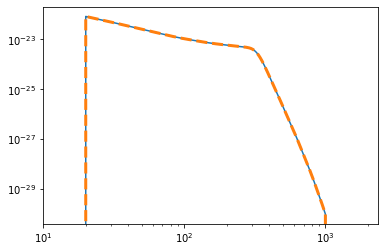

In [83]:
plt.loglog(f, abs(h_int))
plt.loglog(f, abs(hp_data/C_lm), ls='--', lw=3)
plt.xlim(10,)

In [19]:
def antenna_pattern_eff(ra, dec, pol, gps_time, det):
    # We can calcualate the antenna pattern for Hanford at
    # the specific sky location
    d = Detector(det)

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, gps_time)
    #print("fp={}, fc={}".format(fp, fc))
    f_mod = np.sqrt(fp**2 + fc**2)
    
    return fp/f_mod, fc/f_mod

### Signal estimated as template evaluated at MLEs:

In [86]:
# ML estimates for GW170814
mle = dict()
mle["ra"] = 47.75*np.pi/180
mle["dec"] = -np.pi/4
mle["kappa"] = np.pi/4.
mle["psi"] = 0
mle["m1"] = 30.6
mle["m2"] = 25.2
mle["theta_jn"] = np.pi/4
mle["coa_phase"] = np.pi/4
mle["distance"] = 600.
mle["approx"] = "IMRPhenomXPHM"
mle["geocent_time"] = 1186741861.0
modes = ["22", "33", "44"]

In [89]:
h_intrinsic = {}
signal = 0.0
f_min = 20.
f_max = 1000.
df = 0.01
for mode in modes:
    h_intrinsic[mode] = 0.0
    f, h_intrinsic[mode] = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["coa_phase"], mle["approx"])
    l = int(mode[0])
    m = int(mode[1])
    lower_index = f >= f_min
    f = f[lower_index]
    h_intrinsic[mode] = h_intrinsic[mode][lower_index]
    
    upper_index = f <= f_max
    f = f[upper_index]
    h_intrinsic[mode] = h_intrinsic[mode][upper_index]
    
    C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], 0.0, l, m)
    signal += (C_lm*np.cos(mle["kappa"]) -1j*D_lm*np.sin(mle["kappa"]))*h_intrinsic[mode]

In [90]:
H1_psd = H1_psd_int.psd(f)
L1_psd = L1_psd_int.psd(f)
V1_psd = V1_psd_int.psd(f)

(20, 1216.0417906586579)

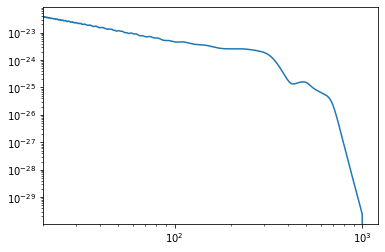

In [91]:
plt.loglog(f, abs(signal))
plt.xlim(20,)

In [92]:
integrand = abs(signal)**2/H1_psd
#integrand = abs(signal)**2/L1_psd
#integrand = abs(signal)**2/V1_psd

In [93]:
snr_H1 = np.sqrt(4*np.sum(integrand)*df)
snr_H1

13.568768154953949

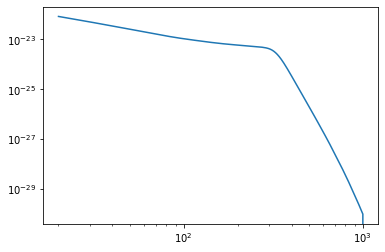

In [94]:
plt.loglog(f, abs(h_intrinsic["22"]))

In [97]:
signal

array([-4.44639696e-25-6.14773514e-26j,
       -3.79251757e-25-2.39883967e-25j,
       -2.46158524e-25-3.75066116e-25j, ...,
       -3.76470962e-29+5.02534858e-30j,
       -3.76397804e-29+5.02315837e-30j,
        0.00000000e+00+0.00000000e+00j])

In [97]:
def bayestarhm_source_model(intrinsic_signal, inclination, distance, kappa, kwargs):
    
    #evaluates only extrinsic part of the waveform
    #Intrinsic part of the signal of every mode should be provided as a dictionary    
    cos_kappa = np.cos(kappa)
    sin_kappa = np.sin(kappa)
    
    signal = 0.0
    
    for mode in kwargs["modes"]:
        l = int(mode[0])
        m = int(mode[1])
        C_lm, D_lm = spher_harms_plus_cross_factors(inclination, 0.0, l, m)
        signal += (C_lm*cos_kappa -1j*D_lm*sin_kappa)*intrinsic_signal[mode]
            
    return signal

In [115]:
def log_bayestarhm_likelihood(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22", "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    if (-1 <= np.cos(params_vec[0]) and np.cos(params_vec[0]) <= 1)*(300 <= params_vec[1] and params_vec[1] < 800 )\
    *(0 <= params_vec[2] and params_vec[2] <=2*np.pi) == 1:
        model = bayestarhm_source_model(h_intrinsic, params_vec[0], params_vec[1], \
                                         params_vec[2], waveform_kwargs)
        likelihood_integrand = abs(signal - model)**2
        for det in detectors:
            psd = eval('%s_psd'%(det))
            log_likelihood += -2*np.trapz(likelihood_integrand/psd, frequency_array) + 2*np.log(params_vec[1])
        #print("inclination = %f, distance = %f, coa_phase = %f, kappa = %f, log_L = %f"%(params_vec[0],params_vec[1], params_vec[2],params_vec[3], log_likelihood))
        return log_likelihood
    else:
        return -np.inf

In [116]:
detectors = ["H1", "L1", "V1"]
#detectors = ["H1"]

In [117]:
n_walkers = 10
ndim = 3
burnin_steps = 500
steps = 10000
guess_value = np.array([np.pi/4.,600, np.pi/4.])

In [118]:
p0_zero = np.ones([n_walkers,ndim])*guess_value
p0 = p0_zero+np.array([np.random.rand(ndim) for i in range(n_walkers)])

In [119]:
t0 = time.time()
sampler = emcee.EnsembleSampler(n_walkers,ndim,log_bayestarhm_likelihood)
p1,lnpos1,rs1 = sampler.run_mcmc(p0,burnin_steps)
sampler.reset()
sampler.run_mcmc(p1,steps)
tf = time.time()
print("Time taken in running Emcee sampler with %d walkers and %d steps = %f"%(n_walkers, steps, (tf-t0)))

Time taken in running Emcee sampler with 10 walkers and 10000 steps = 380.432138


In [68]:
np.save("lnp_w-%d_steps-%d_bsteps-%d_zerolag.npy"%(n_walkers,steps,burnin_steps),sampler.flatchain)

In [120]:
sampler.flatchain

array([[7.92836779e-01, 5.22812670e+02, 8.03464664e-01],
       [7.92836779e-01, 5.22812670e+02, 8.03464664e-01],
       [7.92836779e-01, 5.22812670e+02, 8.03464664e-01],
       ...,
       [8.03238545e-01, 7.93174689e+02, 7.87844126e-01],
       [8.03238545e-01, 7.93174689e+02, 7.87844126e-01],
       [8.03238545e-01, 7.93174689e+02, 7.87844126e-01]])

In [121]:
len(sampler.flatchain[:,0])

100000

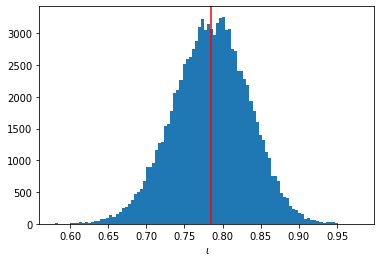

In [122]:
plt.hist(sampler.flatchain[:,0], bins=100)
plt.axvline(x=mle["theta_jn"], c='r')
plt.xlabel("$\iota$")
plt.show()

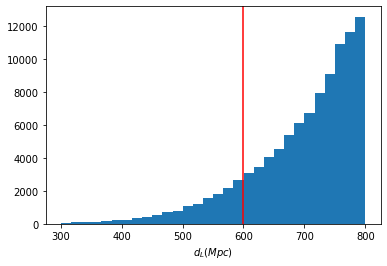

In [123]:
plt.hist(sampler.flatchain[:,1], bins=30)
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L (Mpc)$")
plt.show()

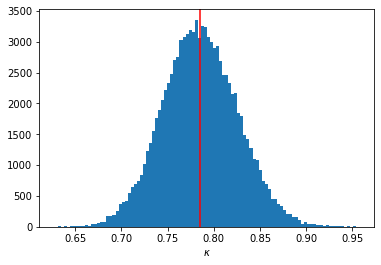

In [124]:
plt.hist(sampler.flatchain[:,2], bins=100)
plt.axvline(x=mle["kappa"], c='r')
#plt.axvline(x=mle["kappa"]+np.pi/2, c='g')
plt.xlabel("$\kappa$")
plt.show()

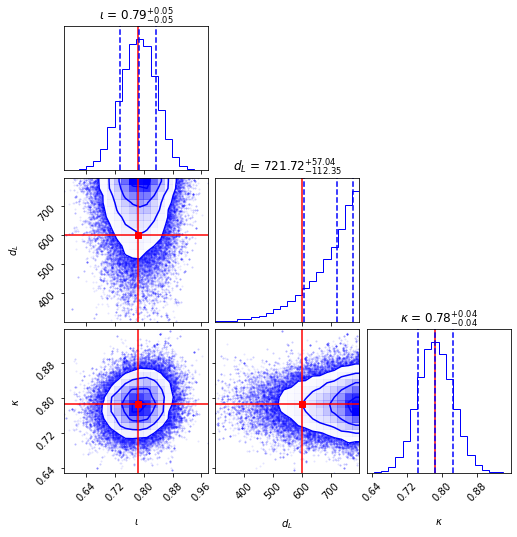

In [127]:
figure = corner.corner(sampler.flatchain, labels=[r"$\iota$", r"$d_L$",  r"$\kappa$"],
                      show_titles=True, color='b', quantiles=[0.16, 0.5, 0.84], truths=[np.pi/4., 600, np.pi/4], truth_color='r')

In [19]:
data = np.load("/home/mukesh/Academics/Bayestar/scripts/lnp_w-50_steps-100000_bsteps-1000_zerolag.npy")

In [20]:
iota = data[:,0]
d = data[:,1]
phic = data[:,2]
kappa1 = data[:,3]

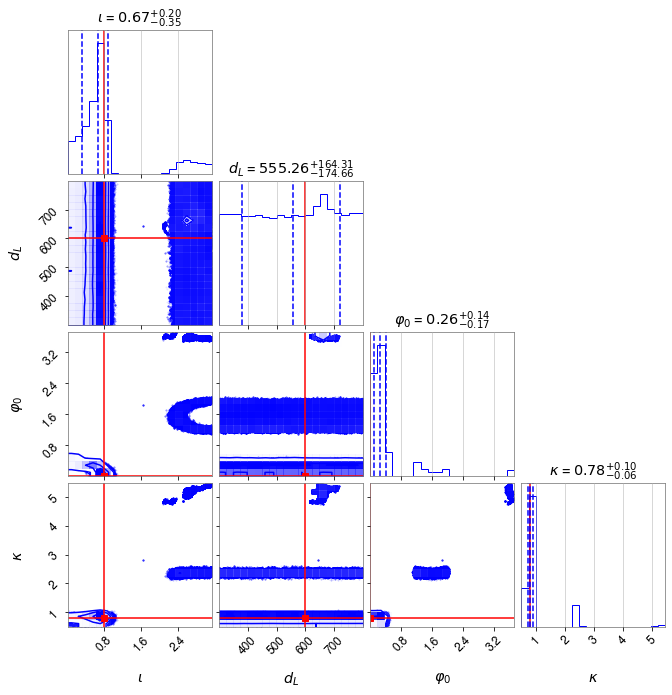

In [198]:
figure = corner.corner(data, labels=[r"$\iota$", r"$d_L$", r"$\varphi_0$", r"$\kappa$"],
                      show_titles=True, color='b', quantiles=[0.16, 0.5, 0.84], truths=[np.pi/4., 600, 0.0, np.pi/4], truth_color='r')

(0, 3)

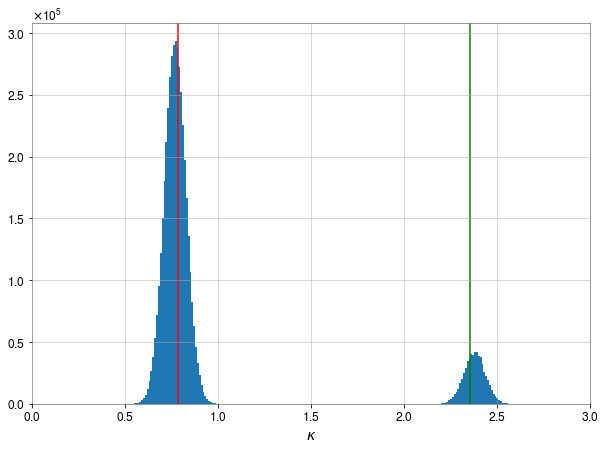

In [21]:
plt.figure(figsize=(10,7))
plt.hist(kappa1, bins=500)
plt.axvline(x=mle["kappa"], c='r')
plt.axvline(x=mle["kappa"]+np.pi/2, c='g')
plt.xlabel("$\kappa$")
plt.xlim(0, 3)
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/kappa_steps_100000_walkers_50_burning_steps_1000.png")

Text(0.5, 0, '$\\varphi_{0}$')

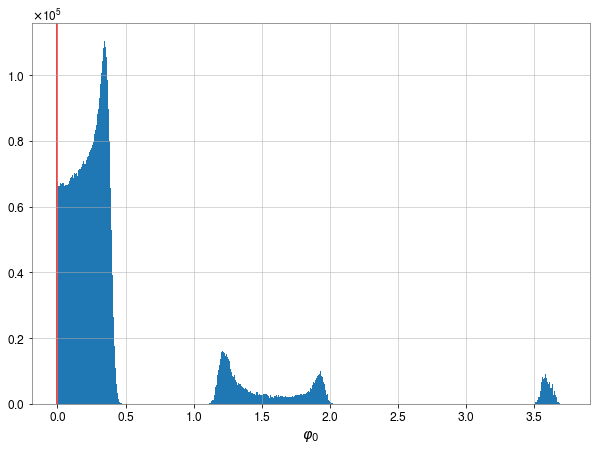

In [22]:
plt.figure(figsize=(10,7))
plt.hist(phic, bins=500)
plt.axvline(x=mle["coa_phase"], c='r')
plt.xlabel(r"$\varphi_{0}$")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/coa_phase_steps_100000_walkers_50_burning_steps_1000.png")

Text(0.5, 0, '$d_L (Mpc)$')

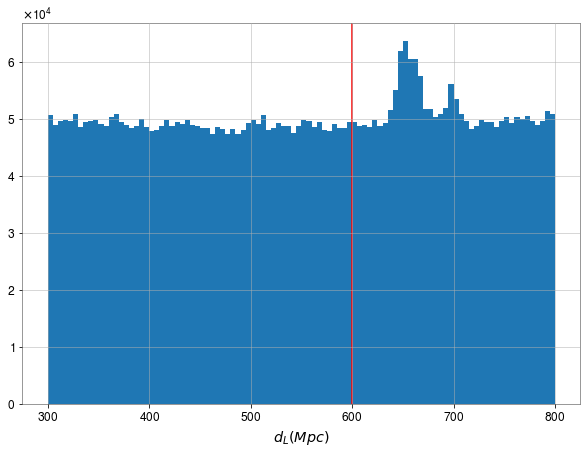

In [23]:
plt.figure(figsize=(10,7))
plt.hist(d, bins=100)
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L (Mpc)$")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/distance_steps_100000_walkers_50_burning_steps_1000.png")

Text(0.5, 0, '$\\iota$')

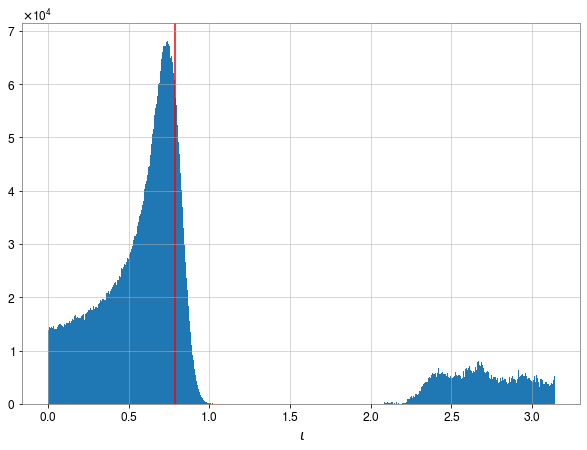

In [24]:
plt.figure(figsize=(10,7))
plt.hist(iota, bins=500)
plt.axvline(x=mle["theta_jn"], c='r')
plt.xlabel("$\iota$")
#plt.savefig("/home/mukesh/Academics/Bayestar/plots/inclination_steps_100000_walkers_50_burning_steps_1000.png")

Text(0.5, 0, '$\\varphi_0$')

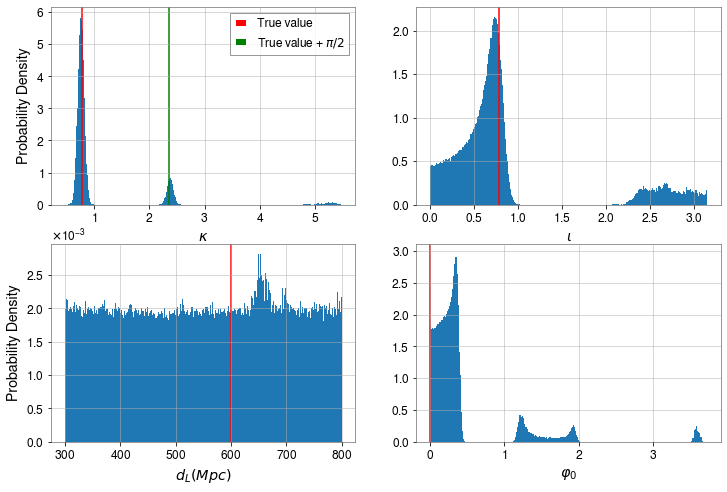

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

ax[0, 0].hist(kappa1, bins=500, density=True)
ax[0, 0].axvline(x=mle["kappa"], c='r', label='True value')
ax[0, 0].axvline(x=mle["kappa"]+np.pi/2, c='g', label='True value + $\pi/2$')
ax[0, 0].set_xlabel("$\kappa$")
ax[0, 0].set_ylabel("Probability Density")
ax[0, 0].legend(loc='best')
#ax[0, 0].set_xlim(0, 3)

ax[0, 1].hist(iota, bins=500, density=True)
ax[0, 1].axvline(x=mle["theta_jn"], c='r')
ax[0, 1].set_xlabel("$\iota$")
#ax[0, 1].set_xlim(0, 3)

ax[1, 0].hist(d, bins=500, density=True)
ax[1, 0].axvline(x=mle["distance"], c='r')
ax[1, 0].set_xlabel("$d_L (Mpc)$")
ax[1, 0].set_ylabel("Probability Density")
#ax[1, 0].set_xlim(0, 3)

ax[1, 1].hist(phic, bins=500, density=True)
ax[1, 1].axvline(x=mle["coa_phase"], c='r')
ax[1, 1].set_xlabel(r"$\varphi_0$")
#ax[0, 1].set_xlim(0, 3)

#fig.savefig("/home/mukesh/Academics/Bayestar/plots/extrinsic_params_4dim_bayestarhm_emcee_sampling.pdf")

## Nested Sampling:

In [26]:
from dynesty import NestedSampler

In [27]:
def log_bayestarhm_like(params_vec):
    
    waveform_kwargs = {}
    waveform_kwargs["modes"] = ["22", "33", "44"]
    frequency_array = f
    log_likelihood = 0.0
    model = bayestarhm_source_model(h_intrinsic, params_vec[0], params_vec[1], params_vec[2], \
                                         params_vec[3], waveform_kwargs)
    #print(signal)
    likelihood_integrand = abs(signal - model)**2
    for det in detectors:
        psd = eval('%s_psd'%(det))
        log_likelihood += -2*np.trapz(likelihood_integrand/psd, frequency_array) + 2*np.log(params_vec[1])
        #print("inclination = %f, distance = %f, coa_phase = %f, kappa = %f, log_L = %f"%(params_vec[0],params_vec[1], params_vec[2],params_vec[3], log_likelihood))
    #print(log_likelihood)
    return log_likelihood

In [28]:
def prior_transform(u):
    
    x = np.array(u)
    
    #print(u[0])
    
    x[0] = np.arccos(u[0] * 2. - 1.)
    
    x[1] = 500*u[1] + 300
    
    x[2] = 2*np.pi*u[2]
    
    x[3] = 2*np.pi*u[3]
    
    return x

In [33]:
sampler = NestedSampler(log_bayestarhm_like, prior_transform, ndim, nlive=2000, bound='none', sample='rwalk')

In [34]:
sampler.run_nested(dlogz=0.1)

24138it [36:41, 10.96it/s, +2000 | bound: 0 | nc: 1 | ncall: 496206 | eff(%):  5.268 | loglstar:   -inf < 40.087 <    inf | logz: 30.345 +/-  0.090 | dlogz:  0.000 >  0.100]


In [35]:
len(sampler.results["samples"][:,0])

26138

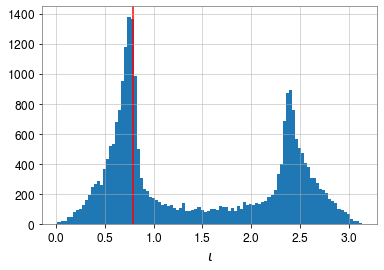

In [36]:
plt.hist(sampler.results["samples"][:,0], bins=100)
plt.axvline(x=mle["theta_jn"], c='r')
plt.xlabel("$\iota$")
plt.show()

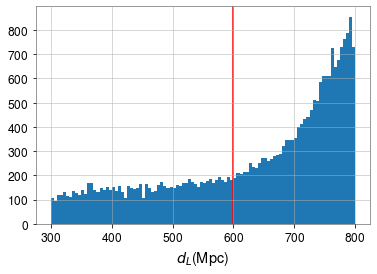

In [37]:
plt.hist(sampler.results["samples"][:,1], bins=100)
plt.axvline(x=mle["distance"], c='r')
plt.xlabel("$d_L$(Mpc)")
plt.show()

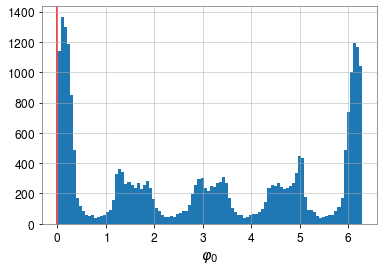

In [38]:
plt.hist(sampler.results["samples"][:,2], bins=100)
plt.axvline(x=mle["coa_phase"], c='r')
plt.xlabel(r"$\varphi_0$")
plt.show()

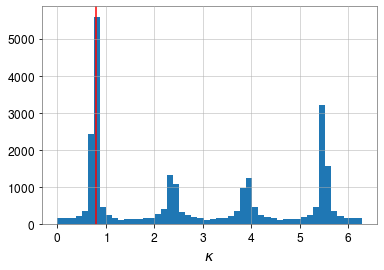

In [39]:
plt.hist(sampler.results["samples"][:,3], bins=50)
plt.axvline(x=mle["kappa"], c='r')
plt.xlabel("$\kappa$")
plt.show()

In [40]:
import corner

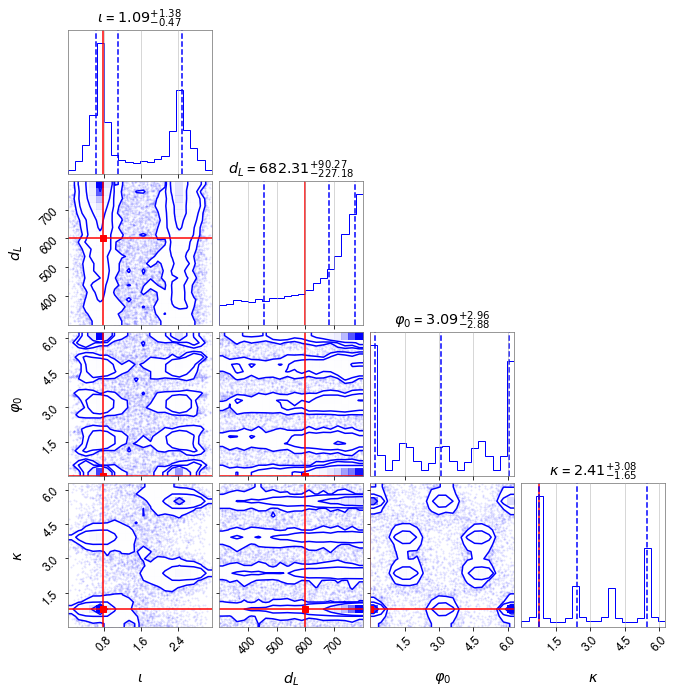

In [41]:
figure = corner.corner(sampler.results["samples"], labels=[r"$\iota$", r"$d_L$", r"$\varphi_0$", r"$\kappa$"],
                      show_titles=True, color='b', quantiles=[0.16, 0.5, 0.84], truths=[np.pi/4., 600, 0.0, np.pi/4], truth_color='r')